The data is available as two attached CSV files:

takehome_user_engagement.csv takehome_users.csv The data has the following two tables:

1] A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:

● name: the user's name

● object_id: the user's id

● email: email address

● creation_source: how their account was created. This takes on one of 5 values: ○ PERSONAL_PROJECTS: invited to join another user's personal workspace ○ GUEST_INVITE: invited to an organization as a guest (limited permissions) ○ ORG_INVITE: invited to an organization (as a full member) ○ SIGNUP: signed up via the website ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)

● creation_time: when they created their account

● last_session_creation_time: unix timestamp of last login

● opted_in_to_mailing_list: whether they have opted into receiving marketing emails

● enabled_for_marketing_drip: whether they are on the regular marketing email drip

● org_id: the organization (group of users) they belong to

● invited_by_user_id: which user invited them to join (if applicable).

2] A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product. Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

We suggest spending 1-­2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better ­­ no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)

In [ ]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [ ]:
users = pd.read_csv('takehome_users.csv',encoding='latin-1', parse_dates=True)

In [ ]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Check out how many users

In [ ]:
print(engagement['user_id'].nunique())

8823


As we can see there were 8823 users.

In [ ]:
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= timedelta(days=days))

In [ ]:
engagement['time_stamp'] = pd.to_datetime(
    engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S'
)

In [ ]:
adopted = engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'


In [ ]:
print('There were {} adopted users'.format(sum(adopted)))


There were 1656 adopted users


As we can see now there were 8823 users total and 1656 adopted users as shown.

In [ ]:
users = users.set_index('object_id')
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis=1, join='inner')
data['adopted_user'] = data['adopted_user'].astype(int)

# EDA
Using Chi-squared test to show the difference

In [ ]:
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(data['creation_source'], data['adopted_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 41.27933208242451	p = 2.3526508745340972e-08


In [ ]:
data.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

Adopted user rate is clearly high in guest_invite and personal_projects.

In [ ]:
data.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [ ]:
def z_test(df, col, target='adopted_user'):
    from statsmodels.stats.weightstats import CompareMeans
    opted_in = df.loc[data[col]==1, target]
    opted_out = df.loc[data[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))
z_test(data, 'opted_in_to_mailing_list')

For opted_in_to_mailing_list, z = 0.7029779128148235, p = 0.4820695142048762


In [ ]:
data.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [ ]:
z_test(data, 'enabled_for_marketing_drip')

For enabled_for_marketing_drip, z = 0.40292649500940264, p = 0.6870022995069656


There's no much different between mailling list and marketing drip.

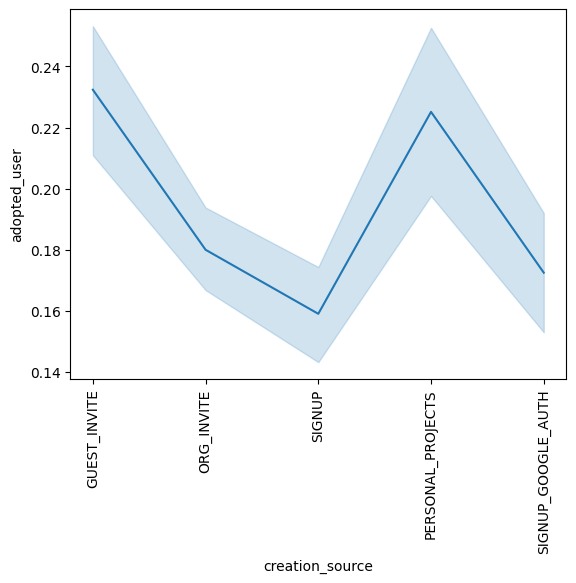

In [ ]:
_ = sns.lineplot(x='creation_source', data=data, y='adopted_user')
_ = plt.xticks(rotation=90)

This image verifies that the creation sources are not very different. So it also verifies the importance of using the Chi-squared test above.

# Feature importance

We might as well imagine the characteristics of "adopted users". How people choose a software that suits them and likes in their daily life is often introduced by friends or their own specific needs. And if the total time users use the software can be compared, then it can be determined that users who meet these characteristics can be regarded as "adopted users". By comparing the dataset, we found that there are creation_time and last_session_creation_time. We can create a new feature called "user historical usage time" to determine whether the user meets the characteristics of "adopted users".

In [ ]:
users['creation_time'] = pd.to_datetime( users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users['user_history'] = users['last_session_creation_time'] - users['creation_time']
users['user_history'] = users['user_history'].dt.days
latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days


In [ ]:
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [ ]:
users.head()

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_history,account_age
user_id,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0,38
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0,196
3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,0.0,437
4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,1.0,374
5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,5.0,498


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        12000 non-null  object 
 1   email                       12000 non-null  object 
 2   creation_source             12000 non-null  object 
 3   opted_in_to_mailing_list    12000 non-null  int64  
 4   enabled_for_marketing_drip  12000 non-null  int64  
 5   org_id                      12000 non-null  int64  
 6   invited_by_user_id          6417 non-null   float64
 7   user_history                8823 non-null   float64
 8   account_age                 12000 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 1.2+ MB


In [ ]:
users = users.drop(['org_id', 'invited_by_user_id'], axis=1)

Here we can see that among the total of 12,000 users, a total of 8,823 users have historical records. But the data is still too large and the screening rate is too high. Because it cannot be determined that users with historical records meet the characteristics of "adopted user".

We need to go back to the steps of eda and make a relationship diagram of user_history and adopted users for data visualization.

In [ ]:
def plot_user_history(df, col, xlabel):
    _ = plt.hist(df.loc[data['adopted_user']==1, col],
                 bins=30, alpha=0.3, color='r', label='adopted user')
    _ = plt.hist(df.loc[data['adopted_user']==0, col],
                 bins=30, alpha=0.3, color='b', label='non-adopted user')
    _ = plt.yscale('loc')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('Number of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])


# Modeling
We selected user history as our important feature, and account_age has the same scale as user history in the dataset. We will use the random forest model affected by scale next.
First we create a dummy variable for the creation source.

# (Need some help for model create.....)

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.7, test_size = 0.3,
                                                random_state = 42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters:', model.best_params_)
print('Best average precision:', model.best_score_)

ValueError: ignored